In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import itertools
import numpy as np
from scipy import stats
from os import listdir
 
sns.set(style="ticks", font_scale=1.3, font="Arial")

# Global variables for plotting

In [2]:
CONDS = [
    "probable", "improbable", "impossible", "inconceivable", "inconceivable_syntactic"
]
LABELS = [
    "probable", "improbable", "impossible", "nonsense"
]
PRETTY_COND_MAP = {
    "probable": "Probable",
    "improbable": "Improbable",
    "impossible": "Impossible",
    "inconceivable": "Inconceivable",
    "inconceivable_syntactic": "Inconceivable-Syntax" 
}
COND_MARKERS = {
    "probable": "o", 
    "improbable": "v", 
    "impossible": "X",
    "inconceivable": "d",
    "inconceivable_syntactic": "s"
}
PRETTY_CONDS = [PRETTY_COND_MAP[c] for c in CONDS]
PRETTY_LABELS = [l.capitalize() for l in LABELS]

NEURAL_MODELS = ["gpt2", "gpt2-medium", "gpt2-xl", "meta-llama/meta-llama-3-8b", "meta-llama/meta-llama-3-70b"]
MODELS = ["infinigram"] + NEURAL_MODELS
PRETTY_MODEL_MAP = {
    "infinigram": "$\\infty$-gram",
    "gpt2": "GPT-2 (124M)",
    "gpt2-medium": "GPT-2 Med (355M)",
    "gpt2-xl": "GPT-2 XL (1.5B)",
    "meta-llama/meta-llama-3-8b": "Llama-3 (8B)",
    "meta-llama/meta-llama-3-70b": "Llama-3 (70B)"
}
PRETTY_MODELS = [PRETTY_MODEL_MAP[m] for m in MODELS]

darkblue, lightblue = "#6E7CB9FF", "#7BBCD5FF"
darkred, lightred = "#ef435e", "#f79f99"
darkorange, lightorange = "#F9AB0EFF", "#FBC559FF"
COND_PAL = {
    "probable": darkblue,
    "improbable": lightblue,
    "impossible": darkorange,
    "inconceivable": darkred,
    "inconceivable_syntactic": lightred,
}

NGRAM_DIR = "../data/exp3_model_surprisal/infinigram"
NGRAM_INDEX = "v4_dolma-v1_7_llama"
SURPRISAL_DIR = "../data/exp3_model_surprisal/surprisals"

def get_steps_tokens(revision):
    if revision is None:
        return None, None
    step_str, token_str = revision.split("-")
    steps = int(step_str.replace("step", ""))
    tokens = int(token_str.replace("tokens", "").replace("B", ""))
    return steps, tokens

def render(outpath=None):
    if outpath is not None:
        plt.savefig(f"../figures/{outpath}", dpi=300, bbox_inches="tight")

# Experiment 1: Modal classification task

In [3]:
# Helper function for labeling whether a response matches the underlying condition.
def is_correct(response, condition):
    condition_coarse = condition.split("_")[0]
    if response == condition_coarse:
        return True
    elif response == "nonsense" and condition_coarse == "inconceivable":
        return True
    else:
        return False

exp1 = pd.read_csv("../data/exp1_human_classification/trial_data.csv")
exp1["response_correct"] = exp1.apply(
    lambda r: is_correct(r.response_label, r.condition),
    axis=1
)
print(f"Experiment 1: {exp1.subject_id.nunique()} unique subjects")

Experiment 1: 149 unique subjects


## Figure 1a

condition
impossible       0.633550
improbable       0.554059
inconceivable    0.829567
probable         0.963888
Name: response_correct, dtype: float64

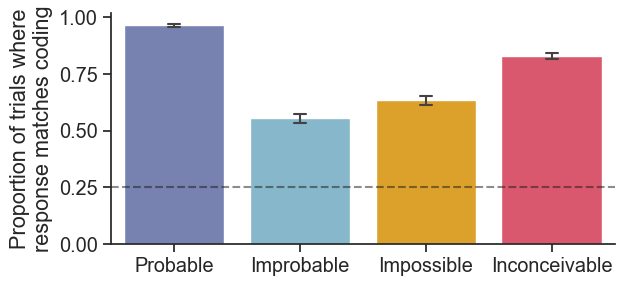

In [4]:
ax = sns.barplot(
    data=exp1, 
    x="condition", 
    y="response_correct", 
    hue="condition",
    legend=False,
    order=CONDS[:-1], 
    palette=COND_PAL,
    capsize=0.1,
    err_kws=dict(linewidth=1.5)
)
ax.set_xticks(range(len(CONDS)-1))
ax.set_xticklabels([c.replace(" ", "\n") for c in PRETTY_CONDS[:-1]])
ax.set_xlabel("")
ax.set_ylabel("Proportion of trials where\nresponse matches coding")
ax.axhline(0.25, linestyle="--", color="k", alpha=0.5)
plt.gcf().set_size_inches(6.5, 3)
sns.despine()
render("fig1a_exp1_proportion_correct.pdf")
exp1.groupby("condition").response_correct.mean()

## Figure 1b

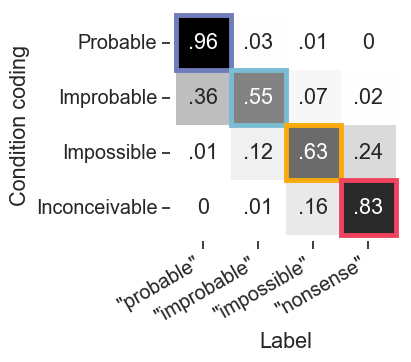

In [5]:
confusion = np.ones((len(CONDS[:-1]), len(LABELS)))
annot = []
for i, cond in enumerate(CONDS[:-1]):
    cond_rows = exp1[exp1.condition==cond]
    annot_row = []
    for j, label in enumerate(LABELS):
        # get rows with this ground-truth condition, and this predicted label
        rows = cond_rows[cond_rows.response_label==label] 
        confusion[i][j] = len(rows) / len(cond_rows)
        s = f"{confusion[i][j]:.2f}"
        if s == "0.00":
            s = "0"
        elif s == "1.00":
            s = "1"
        elif s.startswith("0."):
            s = s[1:]
        annot_row.append(s)
    annot.append(annot_row)

from matplotlib.patches import Rectangle
ax = sns.heatmap(confusion, annot=annot, cmap="Greys", fmt="", square=True, cbar=False)
# Add squares for "accuracy".
annot_coords = {
    "probable": (0, 0),
    "improbable": (1, 1),
    "impossible": (2,2),
    "inconceivable": (3,3)
}
for cond, coords in annot_coords.items():
    ax.add_patch(Rectangle(coords, 1, 1, fill=False, edgecolor=COND_PAL[cond], lw=3.5))
lo, hi = ax.get_xlim()
ax.set_xlim(lo-0.1, hi+0.1)
lo, hi = ax.get_ylim()
ax.set_ylim(lo+0.1, hi-0.1)
    
ax.set_yticklabels(PRETTY_CONDS[:-1], rotation=0)
ax.set_ylabel("Condition coding")
ax.set_xticklabels(['"probable"', '"improbable"', '"impossible"', '"nonsense"'], rotation=30, ha="right")
ax.set_xlabel("Label")
plt.gcf().set_size_inches(3, 3)
render("fig1b_exp1_confusion_matrix.pdf")

# Experiment 2: Human subjective ratings

In [23]:
exp2_raw = pd.read_csv("../data/exp2_human_rating/trial_data.csv")
print(f"Experiment 2: {exp2_raw.subject_id.nunique()} unique subjects")

Experiment 2: 50 unique subjects


## Figure 2

In [24]:
def plot_rating_data(df, metric="response", ylabel="Rating", chance=50, add_stripplot=False):
    # Common keywords for plots.
    strip_kws = dict(alpha=0.1, linewidth=1, dodge=False, legend=False)
    bar_kws = dict(capsize=0.1, err_kws=dict(linewidth=1.5))
    
    # Plot raw responses across conditions.
    data_kws = dict(
        data=df, 
        x="condition", 
        y=metric,
        hue="condition",
        order=CONDS[:-1], 
        palette=COND_PAL
    )
    ax = sns.barplot(**data_kws, **bar_kws)
    if add_stripplot:
        ax = sns.stripplot(**data_kws, **strip_kws)
    ax.set_xticks(
        range(len(CONDS)-1),
        [c.replace(" ", "\n") for c in PRETTY_CONDS[:-1]]
    )
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    ax.axhline(chance, linestyle="--", color="k", alpha=0.5)
    plt.gcf().set_size_inches(6.5,3)
    sns.despine()
    
def remove_outliers(df, col, method="zscore"):
    if method == "zscore":
        mask = (np.abs(stats.zscore(df[col])) < 2)
        df = df[mask]
        return df
    elif method == "iqr":
        iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
        low = df[col].quantile(0.25) - 1.5*iqr
        high = df[col].quantile(0.75) + 1.5*iqr
        return df[(df[col]>=low)&(df[col]<=high)]
    else:
        raise ValueError("Method should be 'zscore' or 'iqr'")

def process_rating_data(df, threshold=2):
    # Normalize ratings within item.
    item_data = df.groupby("item_id").response.describe()
    df["response_item_normalized"] = df.apply(
        lambda r: (r.response - item_data.loc[r.item_id, "mean"]) / item_data.loc[r.item_id, "std"],
        axis=1
    )
    # Normalize ratings within participant.
    subj_data = df.groupby("subject_id").response.describe()
    df["response_subj_normalized"] = df.apply(
        lambda r: (r.response - subj_data.loc[r.subject_id, "mean"]) / subj_data.loc[r.subject_id, "std"],
        axis=1
    )
    return df

def process_rt_data(df, threshold=2):
    # Remove general outliers.
    df = remove_outliers(df, "rt", method="zscore")
    # Normalize RTS within participant.
    subj_rt_data = df.groupby("subject_id").rt.describe()
    df["rt_normalized"] = df.apply(
        lambda r: (r.rt - subj_rt_data.loc[r.subject_id, "mean"]) / subj_rt_data.loc[r.subject_id, "std"],
        axis=1
    )
    return df

exp2_clean = process_rating_data(process_rt_data(exp2_raw))
print(f"Experiment 2 after cleaning: {exp2_clean.subject_id.nunique()} unique subjects")

Experiment 2 after cleaning: 50 unique subjects


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_38015/2360513087.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rt_normalized"] = df.apply(
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_38015/2360513087.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["response_item_normalized"] = df.apply(
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_38015/2360513087.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

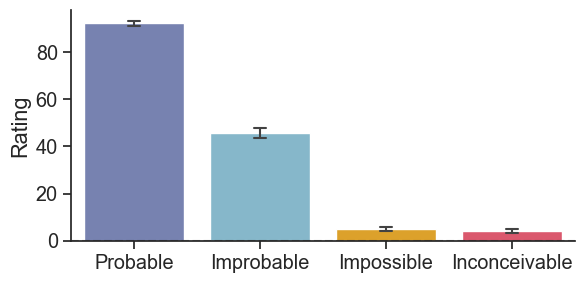

condition
impossible        4.995365
improbable       45.621965
inconceivable     4.159039
probable         92.247674
Name: response, dtype: float64


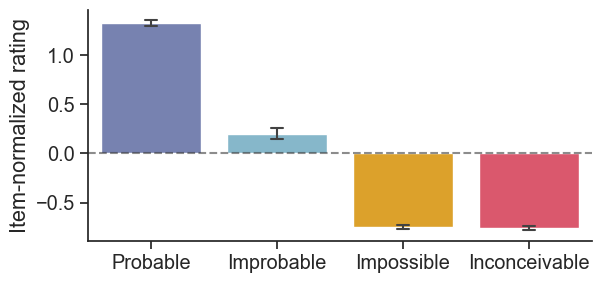

condition
impossible      -0.748861
improbable       0.200468
inconceivable   -0.759885
probable         1.322096
Name: response_item_normalized, dtype: float64


In [8]:
plot_rating_data(exp2_clean, metric="response", ylabel="Rating", chance=0)
render("fig2a_exp2_raw_ratings.pdf")
plt.show()
plt.clf()
print(exp2_clean.groupby("condition").response.mean())

plot_rating_data(exp2_clean, metric="response_item_normalized", ylabel="Item-normalized rating", chance=0)
render("fig2b_exp2_normalized_ratings.pdf")
plt.show()
print(exp2_clean.groupby("condition").response_item_normalized.mean())

In [19]:
exp2_clean.to_csv("../data/exp2_human_rating/clean_data.csv", index=False)

# Experiment 3: Language model evaluation

## Step 1. Read data from neural models

In [9]:
def read_neural_model_data():
    model_df = pd.concat([
        pd.read_csv(f"{SURPRISAL_DIR}/summary_{model.split('/')[-1].lower()}.csv")
        for model in NEURAL_MODELS
    ])
    model_df["model"] = model_df["model"].apply(lambda m: m.lower())
    return model_df

model_df = read_neural_model_data()
model_df.head()

,item_id,eval_prefix,condition,continuation,continuation_sum_logprob,continuation_mean_logprob,model
0,0,He baked a cake inside,probable,an oven.,-7.678192,-2.559397,gpt2
1,0,He baked a cake inside,improbable,an airfryer.,-24.097740,-4.016290,gpt2
2,0,He baked a cake inside,impossible,a freezer.,-9.375153,-3.125051,gpt2
3,0,He baked a cake inside,inconceivable,a sigh.,-15.744316,-5.248105,gpt2
4,0,He baked a cake inside,inconceivable_syntactic,grasp.,-18.422318,-9.211159,gpt2


## Step 2a. Read data from infini-gram model and apply smoothing

In [10]:
def lidstone_smoothing(df, k=1, vocab_size=50257):
    print(f"Performing Lidstone smoothing with k={k}, |V|={vocab_size}")
    df["prob_smoothed"] = df.apply(
        lambda r: (r.cont_cnt + k) / (r.prompt_cnt + (k*vocab_size)),
        axis=1
    )
    df["logprob_smoothed"] = np.log(df.prob_smoothed)
    df["smoothing_k"] = k
    return df

def aggregate_logprobs(df, logprob_var="logprob"):
    g = df.groupby(["item_id", "condition", "continuation", "smoothing_k"])
    sums = g[logprob_var].sum().rename("continuation_sum_logprob").to_frame()
    means = g[logprob_var].mean().rename("continuation_mean_logprob").to_frame()
    agg = sums.join(means).reset_index()
    return agg

def read_ngram_data(**kwargs):
    ngram_df = pd.read_csv(f"{NGRAM_DIR}/probs_{NGRAM_INDEX}.csv")
    ngram_df = lidstone_smoothing(ngram_df, k=0.1, **kwargs)
    ngram_probs_agg = aggregate_logprobs(ngram_df, logprob_var="logprob_smoothed")
    ngram_probs_agg["model"] = "infinigram"
    return ngram_probs_agg

ngram_df = read_ngram_data(vocab_size=50257 if "gpt2" in NGRAM_INDEX else 32000)
ngram_df.head()

Performing Lidstone smoothing with k=0.1, |V|=32000


,item_id,condition,continuation,smoothing_k,continuation_sum_logprob,continuation_mean_logprob,model
0,0,impossible,a freezer,0.1,-23.022429,-7.674143,infinigram
1,0,improbable,an airfryer,0.1,-44.035873,-8.807175,infinigram
2,0,inconceivable,a sigh,0.1,-27.415318,-9.138439,infinigram
3,0,inconceivable_syntactic,grasp,0.1,-10.379722,-10.379722,infinigram
4,0,probable,an oven,0.1,-24.649756,-8.216585,infinigram


In [11]:
# Combine neural and ngram probability data.
full_model_df = pd.concat([model_df, ngram_df]).reset_index().drop(columns=["index"])

# Add surprisal metric.
for metric in ["sum", "mean"]:
    full_model_df[f"continuation_{metric}_surprisal"] = -1 * full_model_df[f"continuation_{metric}_logprob"]
    
# Add "unique id".
full_model_df["unique_id"] = full_model_df["item_id"].astype(str) + "_" + full_model_df["condition"]
    
full_model_df.head()

,item_id,eval_prefix,condition,continuation,continuation_sum_logprob,continuation_mean_logprob,model,smoothing_k,continuation_sum_surprisal,continuation_mean_surprisal,unique_id
0,0,He baked a cake inside,probable,an oven.,-7.678192,-2.559397,gpt2,NaN,7.678192,2.559397,0_probable
1,0,He baked a cake inside,improbable,an airfryer.,-24.097740,-4.016290,gpt2,NaN,24.097740,4.016290,0_improbable
2,0,He baked a cake inside,impossible,a freezer.,-9.375153,-3.125051,gpt2,NaN,9.375153,3.125051,0_impossible
3,0,He baked a cake inside,inconceivable,a sigh.,-15.744316,-5.248105,gpt2,NaN,15.744316,5.248105,0_inconceivable
4,0,He baked a cake inside,inconceivable_syntactic,grasp.,-18.422318,-9.211159,gpt2,NaN,18.422318,9.211159,0_inconceivable_syntactic


## Step 3. Read ngram count data

In [12]:
ngram_counts = pd.read_csv(f"{NGRAM_DIR}/counts_{NGRAM_INDEX}.csv") 
ngram_counts["log_count"] = np.log(ngram_counts["count"])
ngram_counts.head()

,item_id,condition,continuation,approx,count,latency,token_ids,tokens,n_tokens,log_count
0,0,probable,an oven,False,1937872,18.480539,"[385, 288, 854]","['▁an', '▁o', 'ven']",3,14.477101
1,0,improbable,an airfryer,False,6793,2.508879,"[385, 4799, 29888, 719, 261]","['▁an', '▁air', 'f', 'ry', 'er']",5,8.823648
2,0,impossible,a freezer,False,897337,12.892246,"[263, 3889, 3298]","['▁a', '▁free', 'zer']",3,13.707187
3,0,inconceivable,a sigh,False,2472962,12.351274,"[263, 269, 1141]","['▁a', '▁s', 'igh']",3,14.720927
4,0,inconceivable_syntactic,grasp,False,22451743,16.025305,[25274],['▁grasp'],1,16.926879


In [13]:
# Combine surprisal and ngram frequency data.
index = ["item_id", "condition"]
ngram_counts = ngram_counts.set_index(index)[["count", "log_count"]]
full_model_df_with_counts = full_model_df.set_index(index).join(
    ngram_counts, 
    on=index
).reset_index()
full_model_df_with_counts.to_csv(f"../data/exp3_model_surprisal/surprisal_ngram_data.csv", index=False)
full_model_df_with_counts.head()

,item_id,condition,eval_prefix,continuation,continuation_sum_logprob,continuation_mean_logprob,model,smoothing_k,continuation_sum_surprisal,continuation_mean_surprisal,unique_id,count,log_count
0,0,probable,He baked a cake inside,an oven.,-7.678192,-2.559397,gpt2,NaN,7.678192,2.559397,0_probable,1937872,14.477101
1,0,improbable,He baked a cake inside,an airfryer.,-24.097740,-4.016290,gpt2,NaN,24.097740,4.016290,0_improbable,6793,8.823648
2,0,impossible,He baked a cake inside,a freezer.,-9.375153,-3.125051,gpt2,NaN,9.375153,3.125051,0_impossible,897337,13.707187
3,0,inconceivable,He baked a cake inside,a sigh.,-15.744316,-5.248105,gpt2,NaN,15.744316,5.248105,0_inconceivable,2472962,14.720927
4,0,inconceivable_syntactic,He baked a cake inside,grasp.,-18.422318,-9.211159,gpt2,NaN,18.422318,9.211159,0_inconceivable_syntactic,22451743,16.926879


## Figure 3

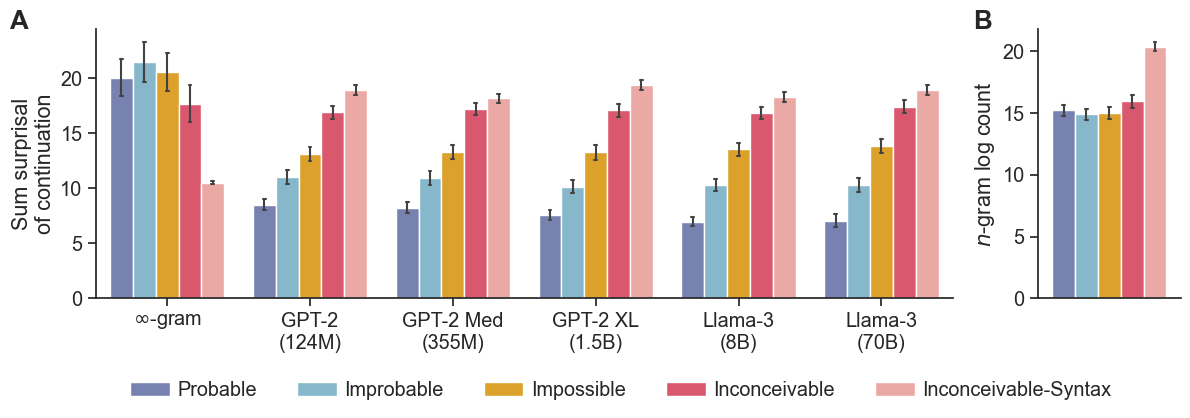

<Figure size 640x480 with 0 Axes>

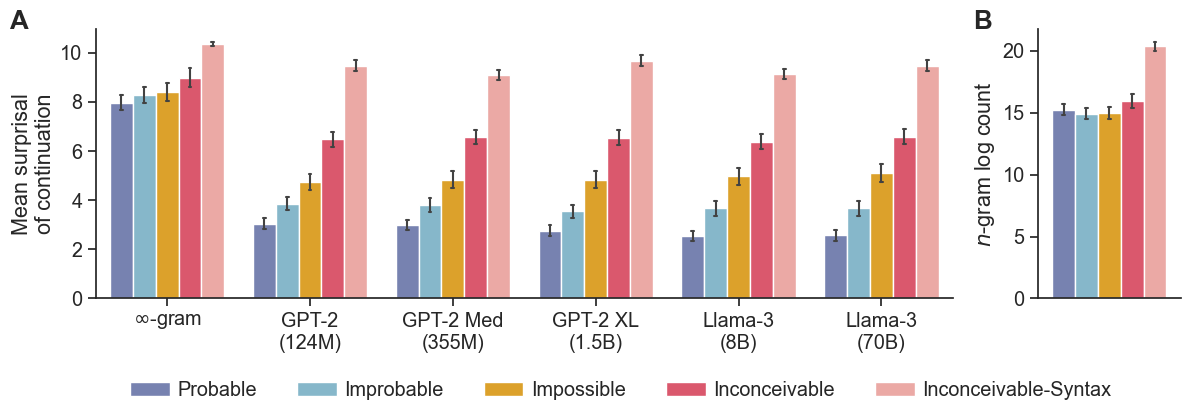

<Figure size 640x480 with 0 Axes>

In [14]:
def plot_surprisals_freqs(df, ngrams, metric="sum", freq_stat="log_count"):
    # Set up subplots.
    fig, axes = plt.subplots(
        nrows=1, ncols=2, 
        sharex=False, sharey=False, 
        figsize=(14,3.5), 
        gridspec_kw={'width_ratios': [len(MODELS), 1]}
    )
    ax0, ax1 = axes
    
    # Common keywords for stripplots and barplots.
    strip_kws = dict(alpha=0.1, linewidth=1, dodge=True, legend=False)
    bar_kws = dict(capsize=0.1, err_kws=dict(linewidth=1.5))
    
    # Plot surprisals across conditions on the first axis.
    surp_kws = dict(
        data=df, 
        x="model", 
        y=f"continuation_{metric}_surprisal",
        order=MODELS,
        hue="condition", 
        hue_order=CONDS,
        palette=COND_PAL,
        ax=ax0
    )
    ax0 = sns.barplot(**surp_kws, **bar_kws)
#     for cond in CONDS:
#         ax0 = sns.stripplot(
#             **strip_kws, 
#             data=df[df.condition==cond],x="model", 
#             y=f"continuation_{metric}_surprisal",
#             order=MODELS,
#             hue="condition", 
#             hue_order=CONDS,
#             marker=COND_MARKERS[cond],
#             palette=COND_PAL, 
#             ax=ax0
#         )
#     ax0 = sns.stripplot(**surp_kws, **strip_kws)
    ax0.set_ylabel(f"{metric.capitalize()} surprisal\nof continuation")
    ax0.set_xlabel("")
    model_labels = []
    for i, m in enumerate(PRETTY_MODELS):
        if len(m.split()) > 1:
            new_m = " ".join(m.split(" ")[:-1]) + "\n" + m.split(" ")[-1]
            model_labels.append(new_m)
        else:
            model_labels.append(m)
    ax0.set_xticks(range(len(MODELS)), model_labels)
    ax0.get_legend().remove()
    
    # Plot ngram frequencies across conditions on the second axis.
    freq_kws = dict(
        data=ngrams, 
        y=freq_stat, 
        hue="condition", 
        hue_order=CONDS,
        palette=COND_PAL,
        ax=ax1
    )
    ax1 = sns.barplot(**freq_kws, **bar_kws)
#     ax1 = sns.stripplot(**freq_kws, **strip_kws)

    ax1.set_xlabel("")
    ax1.set_ylabel("$n$-gram log count")
    ax1.set_xticks([])
    ax1.get_legend().remove()
    
    handles, labels = ax0.get_legend_handles_labels()
    labels = [PRETTY_COND_MAP[l] for l in labels]
    plt.figlegend(
        handles,
        labels, 
        loc="upper center", bbox_to_anchor=(0.5, -0.075), 
        ncol=len(CONDS),
        handletextpad=0.4,
        frameon=False
    )
    plt.subplots_adjust(wspace=0.17)
    sns.despine()
    
    # Add annotations of A and B.
    ax0.text(-0.1, 1, "A", size="large", fontweight="bold", transform=ax0.transAxes)
    ax1.text(-0.45, 1, "B", size="large", fontweight="bold", transform=ax1.transAxes)
    
for metric in ["sum", "mean"]:
    plot_surprisals_freqs(full_model_df, ngram_counts, metric=metric)
    render(f"fig3_exp3_surprisal_{metric}.pdf")
    plt.show()
    plt.clf()

## Figure 4: Training time analyses

In [15]:
olmo_files = [
    f for f in listdir(SURPRISAL_DIR) if f.startswith("summary") and "olmo" in f
]
olmo_df = pd.concat([pd.read_csv(f"{SURPRISAL_DIR}/{f}") for f in olmo_files])
olmo_df[["step", "tokens"]] = olmo_df.apply(
    lambda row: get_steps_tokens(row.revision), 
    axis=1,
    result_type="expand"
)
olmo_df.head()

,item_id,eval_prefix,condition,continuation,continuation_sum_logprob,continuation_mean_logprob,model,revision,step,tokens
0,0,He baked a cake inside,probable,an oven.,-9.461857,-3.153952,allenai/OLMo-7B-0424-hf,step8500-tokens35B,8500,35
1,0,He baked a cake inside,improbable,an airfryer.,-21.031136,-3.505189,allenai/OLMo-7B-0424-hf,step8500-tokens35B,8500,35
2,0,He baked a cake inside,impossible,a freezer.,-11.165411,-3.721804,allenai/OLMo-7B-0424-hf,step8500-tokens35B,8500,35
3,0,He baked a cake inside,inconceivable,a sigh.,-18.528540,-6.176180,allenai/OLMo-7B-0424-hf,step8500-tokens35B,8500,35
4,0,He baked a cake inside,inconceivable_syntactic,grasp.,-19.775327,-9.887663,allenai/OLMo-7B-0424-hf,step8500-tokens35B,8500,35


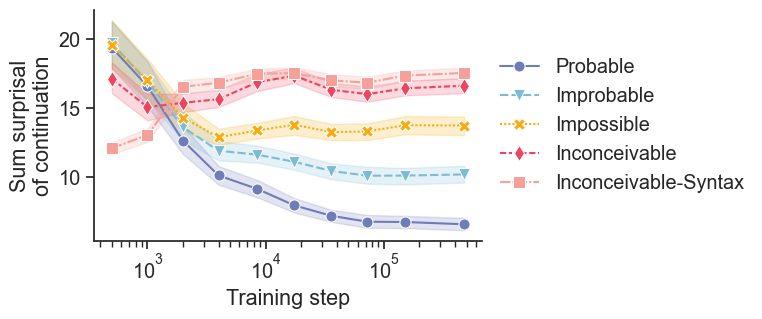

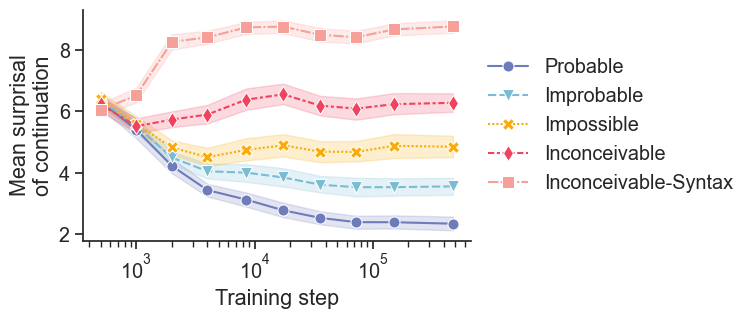

<Figure size 640x480 with 0 Axes>

In [16]:
def plot_surprisal_over_training_time(df, metric="sum"):
    # Add surprisal metric.
    df[f"continuation_{metric}_surprisal"] = -1 * df[f"continuation_{metric}_logprob"]
    ax = sns.lineplot(
        data=df,
        x="step",
        y=f"continuation_{metric}_surprisal",
        hue="condition",
        hue_order=CONDS,
        palette=COND_PAL,
        style="condition",
        markers=[COND_MARKERS[c] for c in CONDS],
        markersize=8
    )
    ax.set_xlabel("Training step")
    ax.set_ylabel(f"{metric.capitalize()} surprisal\nof continuation")
    ax.set_xscale("log")
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles,
        labels=[PRETTY_COND_MAP[c] for c in CONDS],
        loc="center left", bbox_to_anchor=(1, 0.5), frameon=False
    )
    sns.despine()
    plt.gcf().set_size_inches(5,3)

for metric in ["sum", "mean"]:
    plot_surprisal_over_training_time(olmo_df, metric=metric)
    render(f"fig4_exp3_training_surprisal_{metric}.pdf")
    plt.show()
    plt.clf()

## Figure 5

In [29]:
def combine_rating_surprisal_data(ratings, surps, metric="mean"):
    data = []
    s = surps.set_index(["model", "unique_id"])
    for model in MODELS:
        _ratings = ratings.copy()
        _ratings["model"] = model
        for v in [f"continuation_{metric}_surprisal", "log_count"]:
            _ratings[v] = _ratings.apply(
                lambda r: s.loc[model, r.unique_id][v],
                axis=1
            )
        data.append(_ratings)
    return pd.concat(data)

rating_surp_combined = combine_rating_surprisal_data(
    exp2_clean, 
    full_model_df_with_counts, 
    metric="mean"
)
rating_surp_combined.to_csv("../data/exp3_model_surprisal/rating_surprisal_data.csv", index=False)
rating_surp_combined.head()

,subject_id,study_id,session_id,trial_index,internal_node_id,time_elapsed,rt,stimulus,slider_start,response,...,condition,query,session_file_id,unique_id,response_item_normalized,rt_normalized,response_subj_normalized,model,continuation_mean_surprisal,log_count
0,anon_subject_45,65d4fc29515df31cd1044a85,65d664954d11b0c9c36f1cef,1,0.0-1.0-0.0,15738,9480,"<div style=""font-size:20px;""><p>How likely is ...",50,0,...,inconceivable,How likely is it for someone to clean a spill ...,session-65d665f21a7eb,11_inconceivable,-0.855161,2.094753,-0.774031,infinigram,10.383089,16.858015
1,anon_subject_45,65d4fc29515df31cd1044a85,65d664954d11b0c9c36f1cef,2,0.0-1.0-0.1,18522,2781,"<div style=""font-size:20px;""><p>How likely is ...",50,0,...,inconceivable,How likely is it for someone to shave their be...,session-65d665f21a7eb,54_inconceivable,-0.778146,-0.756737,-0.774031,infinigram,10.378162,14.872457
2,anon_subject_45,65d4fc29515df31cd1044a85,65d664954d11b0c9c36f1cef,3,0.0-1.0-0.2,21591,3067,"<div style=""font-size:20px;""><p>How likely is ...",50,0,...,impossible,How likely is it for someone to turn an apple ...,session-65d665f21a7eb,63_impossible,-0.949581,-0.634998,-0.774031,infinigram,6.246377,13.682646
3,anon_subject_45,65d4fc29515df31cd1044a85,65d664954d11b0c9c36f1cef,4,0.0-1.0-0.3,24307,2715,"<div style=""font-size:20px;""><p>How likely is ...",50,100,...,probable,How likely is it for someone to light a candle...,session-65d665f21a7eb,39_probable,1.943126,-0.784830,1.584791,infinigram,6.167082,16.185649
4,anon_subject_45,65d4fc29515df31cd1044a85,65d664954d11b0c9c36f1cef,5,0.0-1.0-0.4,27365,3056,"<div style=""font-size:20px;""><p>How likely is ...",50,0,...,improbable,How likely is it for someone to tighten a bolt...,session-65d665f21a7eb,62_improbable,-0.633215,-0.639680,-0.774031,infinigram,5.257136,13.800407


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_38015/3855937288.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["surprisal"] = df.apply(
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_38015/3855937288.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["surprisal"] = df.apply(
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_38015/3855937288.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

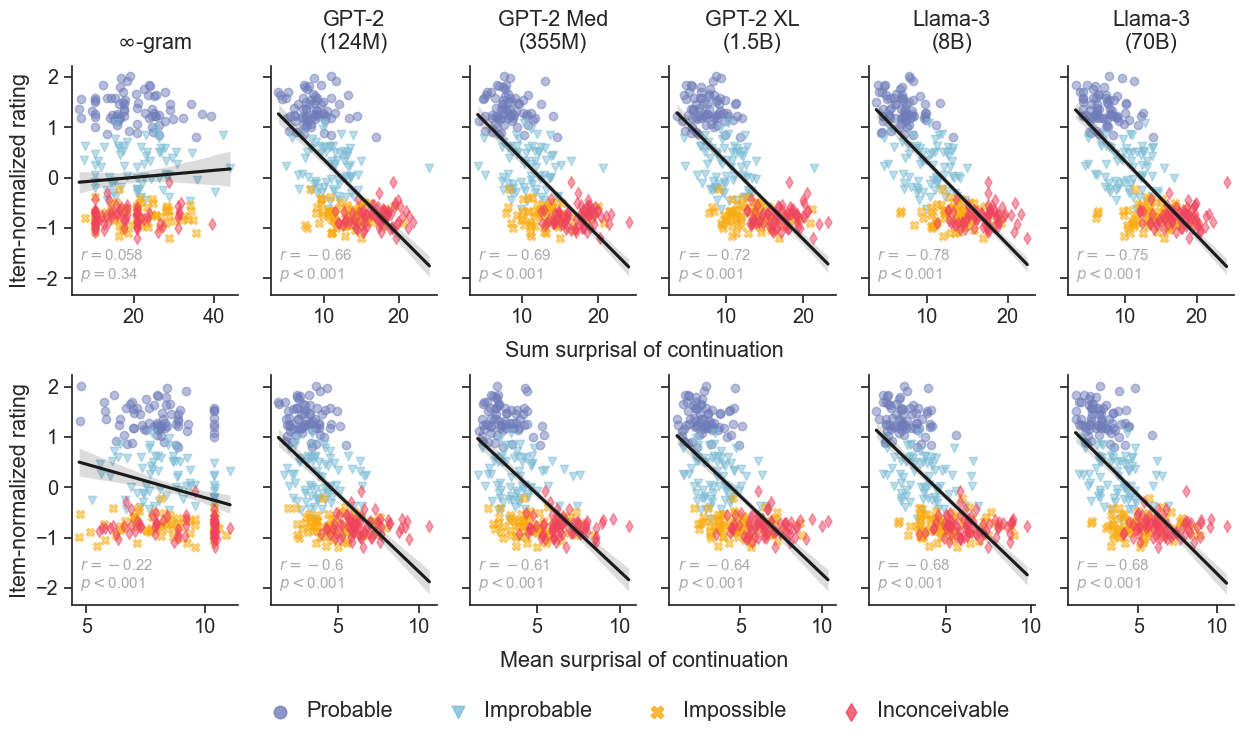

In [21]:
def plot_surprisal_vs_rating_individual(
    df, 
    surp, 
    rating_metric="response", 
    model_metric="mean",
    cond_grouping="condition",
    plot_reg_line=True, 
    reg_color="k",
    legend=True, 
    legend_pos="top",
    ax=None,
    **kwargs
):
    if ax is None:
        ax = plt.gca()

    assert surp.model.nunique() == 1
    surprisals = surp.set_index("unique_id")
    df["surprisal"] = df.apply(
        lambda row: surprisals.loc[row.unique_id][f"continuation_{model_metric}_surprisal"],
        axis=1
    )
    data = df.groupby(
        ["unique_id", cond_grouping]
    )[["surprisal", rating_metric]].mean().reset_index()
        
    # Scatterplot.
    all_xs, all_ys = [], []
    for cond in CONDS[:-1]:
        xs = data[data[cond_grouping]==cond].surprisal
        ys = data[data[cond_grouping]==cond][rating_metric]
        ax.scatter(xs, ys, color=COND_PAL[cond],  marker=COND_MARKERS[cond], label=cond, alpha=0.5)

        all_xs += xs.tolist()
        all_ys += ys.tolist()
    
    # Optionally add regression line.
    if plot_reg_line:
        ax = sns.regplot(x=all_xs, y=all_ys, scatter=False, ax=ax, color=reg_color, **kwargs)
        r, p = stats.pearsonr(all_xs, all_ys)
        if r < 0:
            r_str = f"$r=-${-r:.2g}"
        else:
            r_str = f"$r=${r:.2g}"
        if p < 0.001:
            p_str = "$p<$0.001"
        else:
            p_str = f"$p=${p:.2g}"
        ax.text(
            0.05, 0.05,
            f"{r_str}\n{p_str}", 
            transform=ax.transAxes, 
            size="x-small",
            color="darkgray",
            va="bottom", ha="left"
        )

    # Legend.
    if legend:
        handles, labels = ax.get_legend_handles_labels()
        labels = [PRETTY_COND_MAP[l] for l in labels]
        if legend_pos == "top":
            ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=len(COND_ORDER))
        else:
            ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, handletextpad=0.3)
    sns.despine()
    return ax

def plot_surprisal_vs_rating(df, surp, rating_metric="response_item_normalized"):
    metrics = ["sum", "mean"]
    fig, axes = plt.subplots(
        nrows=len(metrics), 
        ncols=len(MODELS), 
        sharex=False, 
        sharey=True, 
        figsize=(15,7)
    )
    for i, metric in enumerate(metrics):
        for j, model in enumerate(MODELS):
            ax = axes[i][j]
            ax = plot_surprisal_vs_rating_individual(
                df, 
                surp[surp.model==model],
                ax=ax,
                legend=False,
                model_metric=metric,
                rating_metric=rating_metric
            )
            if i == 0:
                model_labels = []
                pretty_model = PRETTY_MODEL_MAP[model]
                if len(pretty_model.split()) > 1:
                    pretty_model = " ".join(pretty_model.split(" ")[:-1]) + "\n" + pretty_model.split(" ")[-1]
                ax.set_title(pretty_model, pad=12)
            
            # Add x-axis label between the middle subplots in each row.
            if j == 2:
                ax.text(
                    1.05, -0.2,
                    f"{metric.capitalize()} surprisal of continuation",
                    ha="center",
                    va="top",
                    transform=ax.transAxes
                )
            
            if j == 0:
                if rating_metric == "response":
                    ax.set_ylabel("Response")
                else:
                    ax.set_ylabel("Item-normalized rating")

    handles, labels = axes[0][0].get_legend_handles_labels()
    legend = plt.figlegend(
        handles=handles,
        labels=[PRETTY_COND_MAP[c] for c in labels],
        loc="upper center", 
        bbox_to_anchor=(0.5, 0), 
        ncol=len(CONDS)-1, 
        frameon=False,
        handletextpad=0.2,
        fontsize="medium",
        markerscale=1.5
    )
    for h in legend.legend_handles:
        h.set_alpha(0.8)
    plt.subplots_adjust(hspace=0.35)
                    

plot_surprisal_vs_rating(
    exp2_clean, 
    full_model_df, 
    rating_metric="response_item_normalized"
)
render("fig5_exp3_rating_vs_surprisal.pdf")

## Supplementary figure: Item-level analyses

/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_38015/1158198011.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
  mat[i][j] = m_df.loc[cond1, cond2].comparison_outcome.mean()
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_38015/1158198011.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
  mat[i][j] = m_df.loc[cond1, cond2].comparison_outcome.mean()
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_38015/1158198011.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
  mat[i][j] = m_df.loc[cond1, cond2].comparison_outcome.mean()
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_38015/1158198011.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
  mat[i][j] = m_df.loc[cond1, cond2].comparison_outcome.mean()
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_38015/1158198011.py:33: PerformanceWarning: indexing past lexsort dep

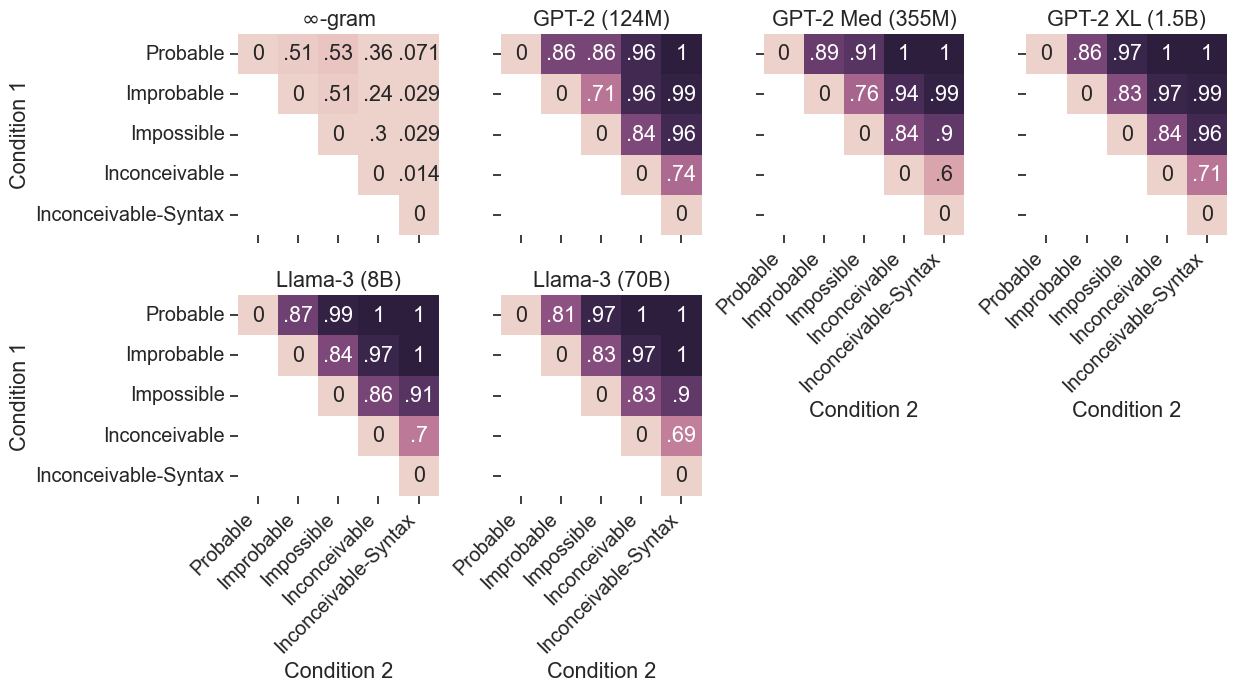

In [18]:
def compute_item_level_scores(df):
    data = []
    for model in df.model.unique():
        m_df = df[df.model==model].set_index(["item_id"])
        for item in m_df.index.unique():
            rows = m_df.loc[item].set_index("condition")
            # Get all combinations of condition pairs.
            for cond1, cond2 in itertools.product(df.condition.unique(), repeat=2):
                res = {"item_id": item, "model": model, "cond1": cond1, "cond2": cond2}
                cond1_label = PRETTY_COND_MAP[cond1]
                cond2_label = PRETTY_COND_MAP[cond2]
                res["cond1_label"] = cond1_label
                res["cond2_label"] = cond2_label
                comparison_name = f"{cond1_label} < {cond2_label}"
                comparison_val = (
                    rows.loc[cond1].continuation_sum_surprisal < 
                    rows.loc[cond2].continuation_sum_surprisal
                )
                res["comparison"] = comparison_name
                res["comparison_outcome"] = comparison_val
                data.append(res)
    data = pd.DataFrame(data)
    return data

def get_heatmap_data(df):
    mats = {}
    for model in df.model.unique():
        m_df = df[df.model==model].set_index(["cond1", "cond2"])
        n_conds = len(CONDS)
        mat = np.zeros((n_conds, n_conds))
        for i, cond1 in enumerate(CONDS):
            for j, cond2 in enumerate(CONDS):
                mat[i][j] = m_df.loc[cond1, cond2].comparison_outcome.mean()
        mats[model] = mat
    return mats

within_item_comparison = compute_item_level_scores(full_model_df)
heatmap_data = get_heatmap_data(within_item_comparison)

fig, axes = plt.subplots(nrows=2, ncols=4, sharey=False, sharex=False)

for flat_idx, model in enumerate(MODELS):
    i, j = np.unravel_index(flat_idx, (2,4))
    ax = axes[i][j]
    mat = heatmap_data[model]
    # Manually tweaked annotations.
    annot = []
    for row in mat:
        annot_row = []
        for x in row:
            s = f"{x:.2g}"
            if s.startswith("0."):
                s = s.replace("0.", ".")
            annot_row.append(s)
        annot.append(annot_row)
    pal = sns.cubehelix_palette(as_cmap=True)
    mask = np.tril(np.ones_like(mat))
    np.fill_diagonal(mask, False)
    ax = sns.heatmap(
        ax=ax,
        data=mat,
        mask=mask,
        vmin=0.5, 
        vmax=1, 
        cmap=pal, 
        annot=annot, 
        fmt="", 
        cbar=False, 
        square=True
    )
    ax.set_title(PRETTY_MODELS[flat_idx])
    ax.set_xticks([0.5+x for x in range(len(PRETTY_CONDS))])
    if i == 1 or (i==0 and j>1):
        ax.set_xticklabels(PRETTY_CONDS, rotation=45, ha="right")
        ax.set_xlabel("Condition 2")
    else:
        ax.set_xticklabels([])
    if j == 0:
        ax.set_yticklabels(PRETTY_CONDS, rotation=0)
        ax.set_ylabel("Condition 1")
    else:
        ax.set_yticklabels([])
        
axes[1][2].set_visible(False)
axes[1][3].set_visible(False)

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.gcf().set_size_inches(13,6)
render("appendix_exp3_item_level_surprisal_comparison_heatmap.pdf")